# Popular Data Science Questions
In this project, we assume the role of Data Analysts working in a company that creates Data Science content. The content can be in form of books, online articles, videos or interactive text. We have been tasked with figuring out the best content to write about for maximum user engagement.

To address this task, we decide to collect data from **[stack exchange](https://en.wikipedia.org/wiki/Stack_Exchange)**, a network of question-and-answer websites. Stack Exchange hosts sites on a multitude of fields and subjects, including Mathematics, Physics, Statistics, and Data Science! Our rationale is simple: If we can identify Data Science questions that people commonly ask, then we can tailor our content to address those topics.

## Why Stack Exchange?
---
1. **Relevance:** Data Science is a multidisciplinary field and Stack Exchange provides a couple of websites that are relevant to our goal. Examples include:
>- [Data Science](https://datascience.stackexchange.com/)
>- [Cross Validated](https://stats.stackexchange.com/) — a statistics site
>- [Artificial Intelligence](https://ai.stackexchange.com/)
>- [Mathematics](https://math.stackexchange.com/)
>- [Stack Overflow](https://stackoverflow.com/)
  
2. **It is easy to identify good posts**: Stack Exchange uses a reputation award system for its questions and answers. Each post is subject to upvotes and downvotes. This makes it easy to identify post that users engage and love.
3. **Established posting guidelines**: Stack Exchange's [Data Science help center](https://datascience.stackexchange.com/help/asking) states that questions should be objective, practical about Data Science, specific and relevant to other users.

The combination of these attributes make Stack Exchange a good source of data for our needs.

## Data Science Stack Exchange
---
Contrary to other Stack Exchange sites, Data Science Stack Exchange (DSSE) is specialized exactly on Data Science. DSSE also has a high percentage of unanswered questions. In fact, a complete list of Stack Exchange websites can be found [here](https://stackexchange.com/sites?view=list#percentanswered), sorted based on the proportion of answered questions. At the time of this writing, Data Science Stack Exchange (DSSE) is one of the bottom 10 sites, having only has 65% of its questions answered. These qualities make DSSE the ideal candidate for our investigation.

_**The DSSE homepage**_<br><br>
<img src='./images/dsse_site.png'>

The left navigation bar on the DSSE hompage comprises five options:
>- [Questions](https://datascience.stackexchange.com/questions) — a list of all questions on the site. Each question contains information on the number of votes, views and answers provided, among many others.
>- [Tags](https://datascience.stackexchange.com/tags) — a list of keywords or labels that categorize questions.<br><br>
<img src='./images/dsse_tags.png'><br><br>
>- [Users](https://datascience.stackexchange.com/users) — a list of users.<br><br>
<img src='./images/dsse_users.png'><br><br>
>- [Companies](https://stackoverflow.com/jobs/companies) — a list of companies hiring tech professionals.<br><br>
<img src='./images/dsse_companies.png'><br><br>
>- [Unanswered](https://datascience.stackexchange.com/unanswered) — a list of unanswered questions.
  
After exploring the website, it is clear that the **tags** will be very useful in categorizing content, saving us the trouble of doing it ourselves. The tags can also help us identify how many questions are asked about each subject.

## SEDE: The Stack Exchange Data Explorer
---
Stack Exchange provides a public database for each of its websites. We can use [this link](https://data.stackexchange.com/datascience/query/new) to query and explore the Data Science Stack Exchange database for information on posts. It is important to note that the database is designed to be queried with the [Transact-SQL (Microsoft's SQL)](https://docs.microsoft.com/en-us/sql/t-sql/language-reference?view=sql-server-ver16) dialect.

After exploring the database, we found a few tables that seem relevant to our analysis:
>- **Posts:** Contains comprehensive information about posts, including the creation date, tags, number of answers, views and upvotes among many more.
>- **Tags:** Holds information about different tags including the number of times they have been used on the site. However, it does not provide time-series information to help us identify if a tag was popular in the past or present.
>- **PostTags:** Contains information on posts and their tags alone. Similar to the Tags table, time series information is absent.
>- **TagSynonyms:** Provides information on tags and alternative names that have been assigned to them by site administrators. Time series information is absent.

Given the absence of time-series information in the **Tags**, **PostTags** and **TagSynonyms** table, and considering that the **Posts** table already contains the relevant information about tags, we will use the information in the posts table alone.

## The Posts Table
---
The Posts Table has **23 columns**. We will focus only on those that seem relevant to our goal:

> (1.) **Id:** An identification number for the post.<br>
> (2.) **PostTypeId:** An identification number for the type of post. The **eight** unique post types are shown below:<br><br>
<img src='./images/post_types.png'><br><br>
> (3.) **CreationDate:** The date and time of creation of the post.<br>
> (4.) **Score:** The post's score.<br>
> (5.) **ViewCount:** How many times the post was viewed.<br>
> (6.) **Tags:** What tags were used.<br>
> (7.) **AnswerCount:** How many answers the question got (only applicable to question posts).<br>
> (8.) **FavoriteCount:** How many times the question was favored.

We are primarily interested with posts that are questions. Other post types are not relevant at the moment. Before proceeding, we can check how many posts on the site are questions, relative to other posts. 

_**The query below (run on Tuesday, August 23, 2022):**_

```
       SELECT PostTypes.Name AS post_type,
              COUNT(*) AS num_posts
         FROM Posts
        INNER JOIN PostTypes
           ON Posts.PostTypeId = PostTypes.Id
        GROUP BY PostTypes.Name
        ORDER BY 2 DESC;

```

_**Yields the following result:**_<br><br>
<img src='./images/num_posts.png'
     height = 300
     width = 300/>
     
It is clear that due to their low volume, anything that isn't questions or answers is mostly inconsequential. We have **34,118** records as questions. Since we're only interested in recent posts, we will limit our analysis to **question posts from January 2021 till date (August 23, 2022)**.

## Getting the Data
---
To obtain the relevant data from the database, we run the following query:
```
        SELECT Id,
               PostTypeId,
               CreationDate,
               Score,
               ViewCount,
               Tags,
               AnswerCount,
               FavoriteCount
          FROM Posts
         WHERE YEAR(CreationDate) > 2020
               AND PostTypeId = 1
         ORDER BY CreationDate;
```
The first five rows of the query result are shown below. The `csv` file was downloaded locally then treated as file-on-hand for analysis:<br><br>
<img src='./images/questions_query.png'/>

## Importing Libraries
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib Inline
%config InlineBackend.figure_format = 'retina'

## Assessing the Data
---

In [2]:
df = pd.read_csv('./questions_from_2021.csv', parse_dates = ['CreationDate'])
df.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,87391,1,2021-01-01 03:10:42,1,44,<decision-trees>,1,NaN
1,87392,1,2021-01-01 07:28:07,0,86,<machine-learning><python><deep-learning><imag...,1,NaN
2,87393,1,2021-01-01 08:07:33,1,22,<neural-network><deep-learning><inception>,0,NaN
3,87395,1,2021-01-01 10:31:51,1,54,<machine-learning><cloud><federated-learning>,1,1.0
4,87404,1,2021-01-01 18:00:21,1,93,<reinforcement-learning><openai-gym>,1,NaN


- Favorite count has some missing values.
- The tags column also contains information aboout different tags, which makes the data untidy at the moment. State the tidiness principles here.
- We can examine the number of missing values in each column. We also need to be sure of their datatypes.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9145 entries, 0 to 9144
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             9145 non-null   int64         
 1   PostTypeId     9145 non-null   int64         
 2   CreationDate   9145 non-null   datetime64[ns]
 3   Score          9145 non-null   int64         
 4   ViewCount      9145 non-null   int64         
 5   Tags           9145 non-null   object        
 6   AnswerCount    9145 non-null   int64         
 7   FavoriteCount  715 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 571.7+ KB


- Only the FavoriteCount column has the wrong datatype, probably because of the presence of missing values. 
- It is easy to deal with the missing values in this column. The most likely reason why a post might have zero favorite count is when users do not add it to their favorites list.

## Cleaning the Data
---
Remember to make a copy before cleaning

### Favorite count column

In [4]:
# fill missing values in favorite count with 0
df.FavoriteCount.fillna(0, inplace = True)

# Cast the column to integer type
df.FavoriteCount = df.FavoriteCount.astype('int')

In [5]:
# Verify that null records have been replaced
assert not df.FavoriteCount.isnull().any()

# verify the datatype of the Favorite count column
df.FavoriteCount.dtype

dtype('int64')

### Tags column
Each question can only have a maximum of [5 tags](https://meta.stackexchange.com/a/18879)

In [6]:
# Expand tags into seperate columns
df[['Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5']] = (df.Tags.str.replace('<', '')
                                                       .str.rstrip('>')
                                                       .str.split('>', expand=True)
                                               )

# Drop the tags column
df.drop(columns = 'Tags', inplace=True)

In [7]:
df.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,AnswerCount,FavoriteCount,Tag1,Tag2,Tag3,Tag4,Tag5
0,87391,1,2021-01-01 03:10:42,1,44,1,0,decision-trees,None,None,None,None
1,87392,1,2021-01-01 07:28:07,0,86,1,0,machine-learning,python,deep-learning,image-classification,image-preprocessing
2,87393,1,2021-01-01 08:07:33,1,22,0,0,neural-network,deep-learning,inception,None,None
3,87395,1,2021-01-01 10:31:51,1,54,1,1,machine-learning,cloud,federated-learning,None,None
4,87404,1,2021-01-01 18:00:21,1,93,1,0,reinforcement-learning,openai-gym,None,None,None


Data is still untidy. Quote data tidiness rules here. Tags spread across multiple variables

In [8]:
# Reduce all tags to one column
df_copy = pd.melt(df, 
                  id_vars = df.columns[:7],
                  value_vars = ['Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5'], 
                  var_name= 'TagNumber', 
                  value_name= 'TagName'
                 )

In [9]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45725 entries, 0 to 45724
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             45725 non-null  int64         
 1   PostTypeId     45725 non-null  int64         
 2   CreationDate   45725 non-null  datetime64[ns]
 3   Score          45725 non-null  int64         
 4   ViewCount      45725 non-null  int64         
 5   AnswerCount    45725 non-null  int64         
 6   FavoriteCount  45725 non-null  int64         
 7   TagNumber      45725 non-null  object        
 8   TagName        28955 non-null  object        
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 3.1+ MB


## Most Used and Most Viewed
---

In [10]:
df_copy.groupby('TagName').size().sort_values(ascending=False).reset_index(name='count').head(10)

a = (df_copy.groupby('TagName').size()
                               .reset_index(name='count')
                               .sort_values(by='count')
    )

In [11]:
def compute_totals(df, grouping_col, total_col, total_name):
    result = (df.groupby(grouping_col)[total_col].sum()
                                        .reset_index(name= total_name)
                                        .sort_values(by= total_name)
             )
                    
    return result

In [12]:
a.head()

,TagName,count
314,learnability,1
477,pytorch-geometric,1
298,kendalls-tau-coefficient,1
389,ndcg,1
302,knime,1


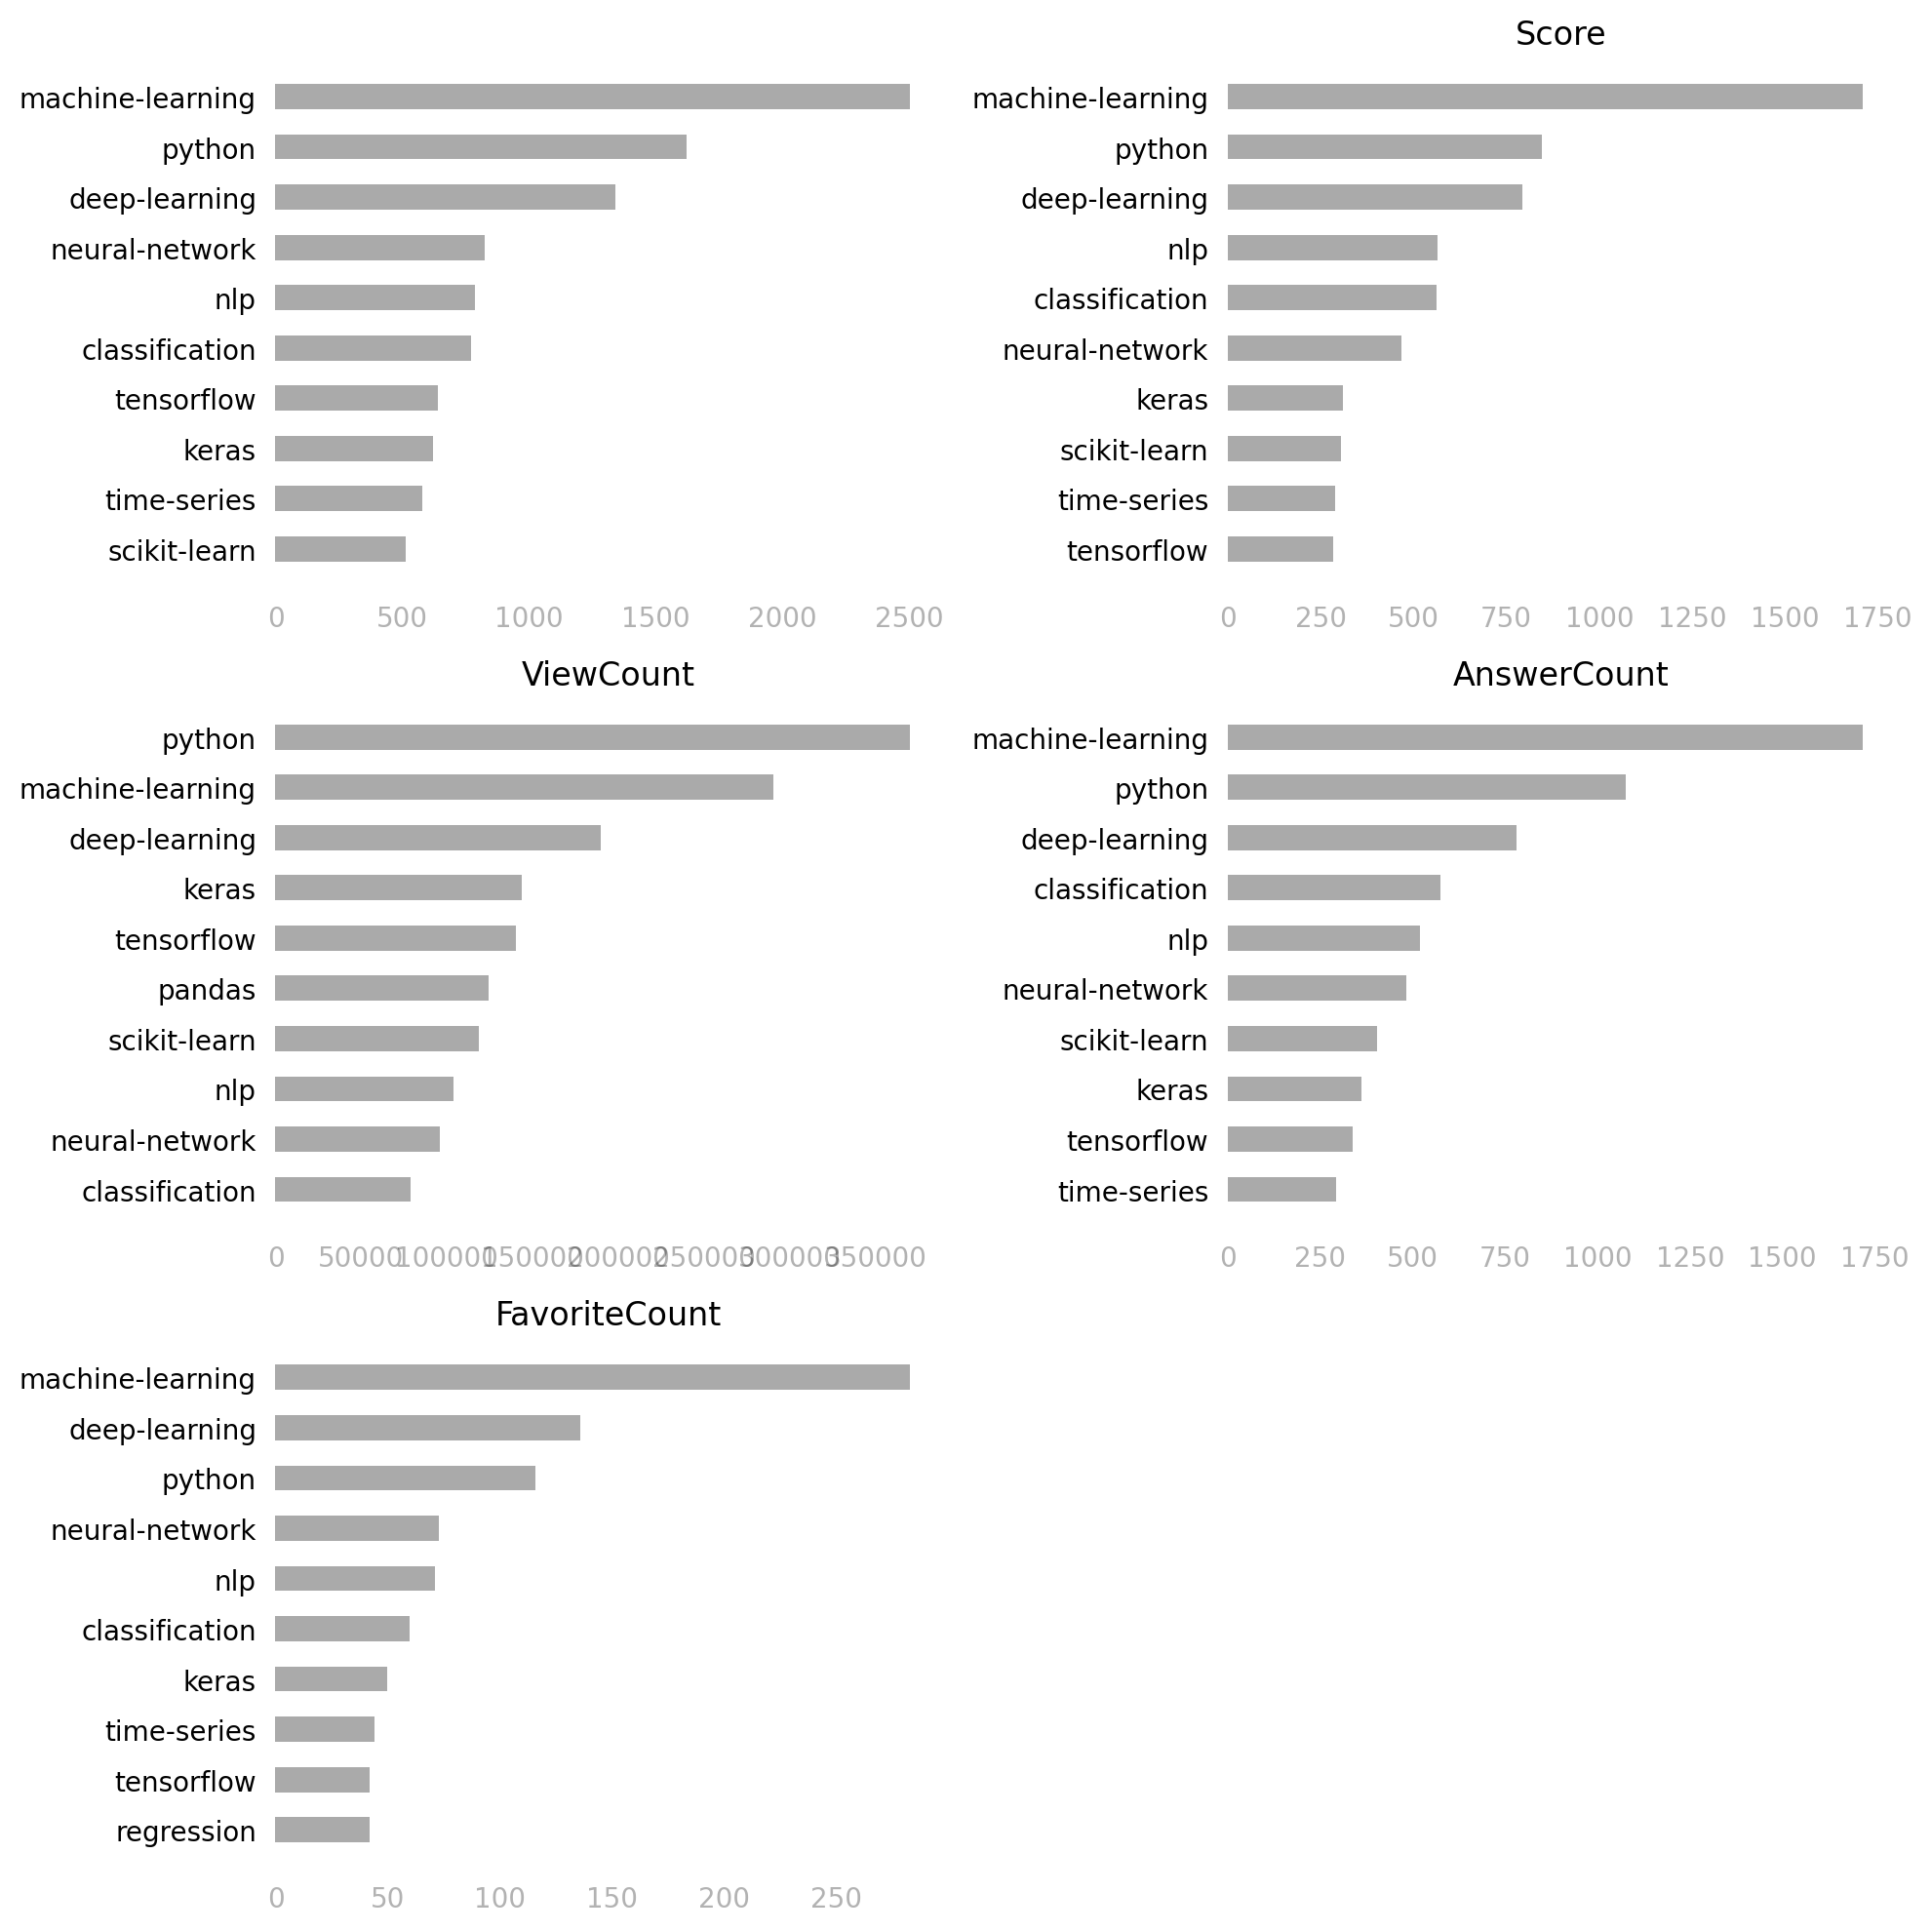

In [41]:
plt.style.use('default')

fig = plt.figure(figsize=(10, 10))

plt.subplot(3, 2, 1)
plt.barh(data = a.tail(10), y= 'TagName', width= 'count', height=0.5, color='#aaa')

col_list = ['Score', 'ViewCount', 'AnswerCount', 'FavoriteCount']
for i, col in zip(range(2, 6), col_list):
    plt.subplot(3, 2, i)
    table = compute_totals(df_copy, 'TagName', col, 'total')
    plt.barh(data = table.tail(10), y='TagName', width='total', height=0.5, color='#aaa')
    plt.title(col)

for ax in fig.get_axes():
    plt.sca(ax)
    sns.despine(left=True, bottom=True)
    ax.tick_params(left=False, bottom=False)
    plt.xticks(size=10, alpha=0.3)
    
plt.tight_layout()